In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor


In [3]:
df = pd.read_csv("datasets/hotel_limpo.csv")
print("Dimensões:", df.shape)
df.head()

Dimensões: (4825, 36)


,reserva_id,cliente_id,data_checkin,data_checkout,noites,antecedencia_dias,num_hospedes,tipo_quarto,motivo_viagem,canal_reserva,...,rating_limpeza,rating_staff,rating_localizacao,rating_geral,fez_reclamacao,preco_quarto_noite,gasto_quarto_total,gasto_extras_total,gasto_total,desconto_aplicado
0,H004323,C002561,2023-07-14,2023-07-16,2,133,2,Standard,Evento,Booking,...,4.0,4.0,5,4,Não,103.90,207.80,18.63,226.43,0.0
1,H004501,C002274,2024-10-21,2024-10-24,3,3,4,Familiar,Business,Booking,...,5.0,4.0,4,4,Não,170.15,510.45,111.54,621.99,0.0
2,H005429,C007773,2024-07-19,2024-07-24,5,60,2,Superior,Lazer,Booking,...,4.0,5.0,4,5,Não,168.96,844.80,208.39,1053.19,0.0
3,H003793,C001820,2023-11-12,2023-11-16,4,12,1,Standard,Lazer,Booking,...,4.0,5.0,5,5,Não,91.91,367.64,223.22,590.86,0.0
4,H003627,C002259,2024-09-11,2024-09-13,2,79,2,Standard,Lazer,Direto,...,5.0,5.0,4,4,Não,102.11,204.22,128.92,333.14,0.0


In [4]:
# Converter target 'foi_spa' em binário (1=Sim, 0=Não)
df["foi_spa"] = (
    df["foi_spa"]
    .astype(str)
    .str.lower()
    .replace({"sim": 1, "não": 0, "nao": 0, "true": 1, "false": 0})
).astype(int)

# Remover linhas sem target
df = df.dropna(subset=["foi_spa", "gasto_total"])

print("Após limpeza:", df.shape)


Após limpeza: (4825, 36)


/var/folders/zn/76llcf_53y1gktzpnrpfpcdr0000gn/T/ipykernel_12421/287981135.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"sim": 1, "não": 0, "nao": 0, "true": 1, "false": 0})


In [5]:
# CLASSIFICAÇÃO — Prever uso do SPA
target = "foi_spa"

# Remover colunas que não devem ser usadas como features
irrelevantes = [
    "reserva_id", "cliente_id", "data_checkin", "data_checkout",
    "gasto_total", "gasto_quarto_total", "gasto_extras_total",
    "gasto_spa", "num_massagens"  # 👈 adicionadas para evitar vazamento
]

X = df.drop(columns=[c for c in irrelevantes if c in df.columns] + [target], errors="ignore")
y = df[target]

# Codificar variáveis categóricas
X = pd.get_dummies(X, drop_first=True)

print("Features finais:", X.shape)


Features finais: (4825, 32)


In [6]:
# Divide o conjunto de dados em treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Treino:", X_train.shape, "Teste:", X_test.shape)

Treino: (3377, 32) Teste: (1448, 32)



=== Regressão Logística ===
Accuracy: 0.626
Precision: 0.622
Recall: 0.484
F1-Score: 0.544


/Users/luana/Desktop/Projeto Final/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


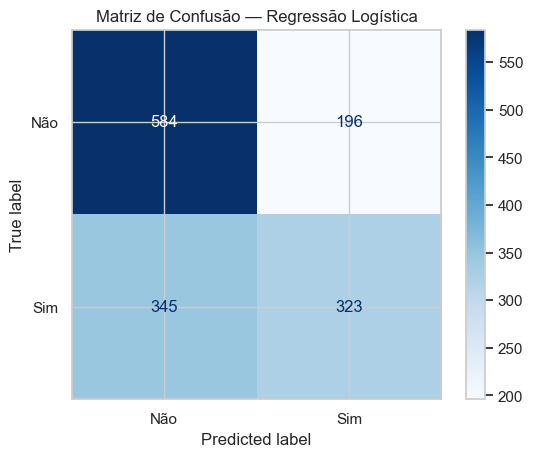


=== Árvore de Decisão ===
Accuracy: 0.555
Precision: 0.518
Recall: 0.485
F1-Score: 0.501


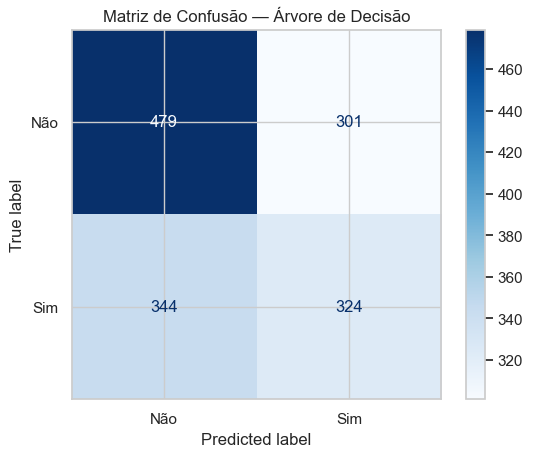


=== Random Forest ===
Accuracy: 0.601
Precision: 0.587
Recall: 0.455
F1-Score: 0.513


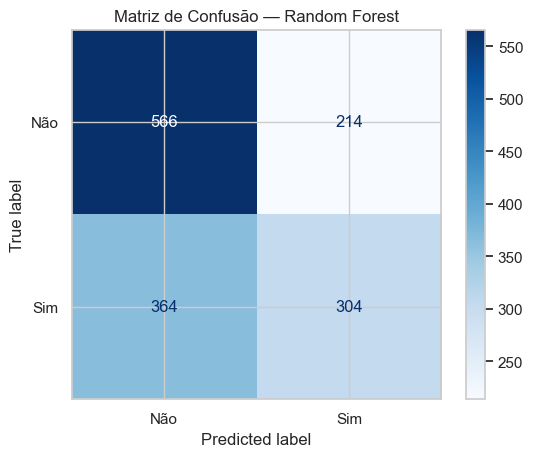

,Modelo,Accuracy,Precision,Recall,F1
0,Regressão Logística,0.626381,0.622351,0.483533,0.544229
2,Random Forest,0.600829,0.586873,0.455090,0.512648
1,Árvore de Decisão,0.554558,0.518400,0.485030,0.501160


In [7]:
# Dicionário com três modelos de classificação que serão testados
# Cada chave é o nome do modelo (para exibição) e o valor é o objeto do modelo
models = {
    "Regressão Logística": LogisticRegression(max_iter=1000),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results_class = []
# Loop para treinar e avaliar cada modelo do dicionário
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results_class.append([name, acc, prec, rec, f1])
    
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1-Score: {f1:.3f}")
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Não", "Sim"]).plot(cmap="Blues")
    plt.title(f"Matriz de Confusão — {name}")
    plt.show()

# Comparar resultados
df_results_class = pd.DataFrame(results_class, columns=["Modelo","Accuracy","Precision","Recall","F1"])
display(df_results_class.sort_values("F1", ascending=False))


In [8]:
# REGRESSÃO — Prever gasto_total
target = "gasto_total"

# Remover colunas que causam vazamento
irrelevantes = [
    "reserva_id", "cliente_id", "data_checkin", "data_checkout",
    "foi_spa",                      # comportamento pós-estadia
    "gasto_spa", "gasto_quarto_total", "gasto_extras_total",  # usados no cálculo do total
    "preco_quarto_noite", "noites", "desconto_aplicado"       # fortemente correlacionados
]

Xr = df.drop(columns=[c for c in irrelevantes if c in df.columns] + [target], errors="ignore")
yr = df[target]

# Codificar variáveis categóricas
Xr = pd.get_dummies(Xr, drop_first=True)

print("Features finais para regressão:", Xr.shape)


Features finais para regressão: (4825, 30)


In [9]:
# Calcula a correlação de todas as variáveis numéricas com a variável alvo 'gasto_total'
corr = df.corr(numeric_only=True)["gasto_total"].sort_values(ascending=False)
print(corr.head(15))


gasto_total               1.000000
gasto_quarto_total        0.955384
noites                    0.715323
gasto_extras_total        0.535631
preco_quarto_noite        0.475613
num_massagens             0.339627
gasto_spa                 0.328881
foi_spa                   0.293416
desconto_aplicado         0.209620
antecedencia_dias         0.117748
num_vezes_room_service    0.105507
rating_limpeza            0.095709
num_hospedes              0.092940
rating_staff              0.074718
consumo_minibar           0.071483
Name: gasto_total, dtype: float64


In [10]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.3, random_state=42)
print("Treino:", Xr_train.shape, "Teste:", Xr_test.shape)


Treino: (3377, 30) Teste: (1448, 30)


In [11]:
models_reg = {
    "Regressão Linear": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

results_reg = []

for name, model in models_reg.items():
    model.fit(Xr_train, yr_train)
    y_pred = model.predict(Xr_test)
    
    mae = mean_absolute_error(yr_test, y_pred)
    rmse = np.sqrt(mean_squared_error(yr_test, y_pred))
    r2 = r2_score(yr_test, y_pred)
    
    results_reg.append([name, mae, rmse, r2])
    
    print(f"\n=== {name} ===")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.3f}")
    
# Comparar resultados
df_results_reg = pd.DataFrame(results_reg, columns=["Modelo","MAE","RMSE","R²"])
display(df_results_reg.sort_values("R²", ascending=False))



=== Regressão Linear ===
MAE: 186.89
RMSE: 234.47
R²: 0.353

=== Random Forest Regressor ===
MAE: 188.15
RMSE: 237.45
R²: 0.336

=== Gradient Boosting Regressor ===
MAE: 183.28
RMSE: 230.60
R²: 0.374


,Modelo,MAE,RMSE,R²
2,Gradient Boosting Regressor,183.281615,230.604838,0.374052
0,Regressão Linear,186.891662,234.470728,0.352890
1,Random Forest Regressor,188.151823,237.450142,0.336339


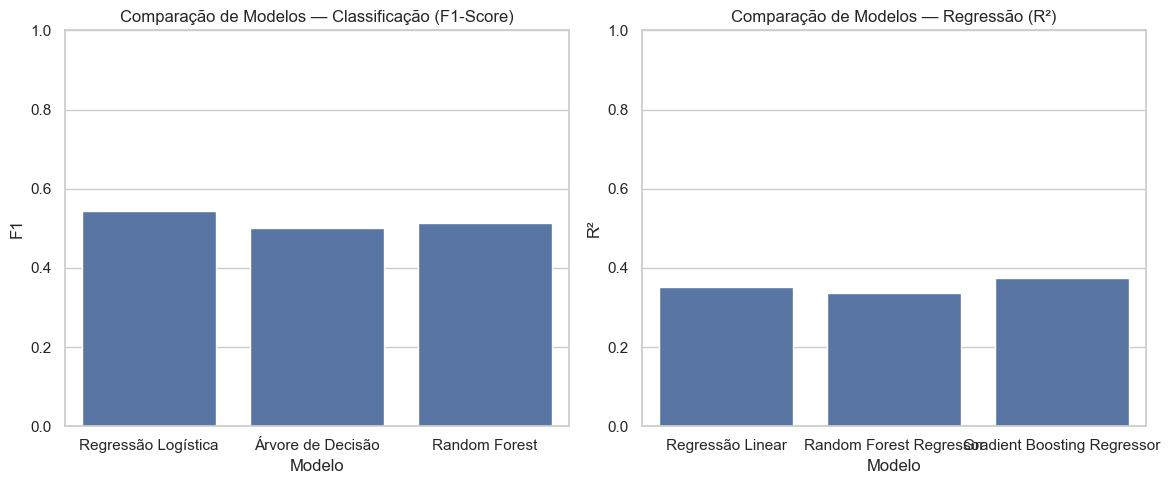

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Classificação
sns.barplot(data=df_results_class, x="Modelo", y="F1", ax=axes[0])
axes[0].set_title("Comparação de Modelos — Classificação (F1-Score)")
axes[0].set_ylim(0, 1)

# Regressão
sns.barplot(data=df_results_reg, x="Modelo", y="R²", ax=axes[1])
axes[1].set_title("Comparação de Modelos — Regressão (R²)")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [13]:
# ======================================================
# 🏁 RESUMO FINAL — MELHORES MODELOS
# ======================================================

# Melhor modelo de CLASSIFICAÇÃO (maior F1)
best_class = df_results_class.loc[df_results_class["F1"].idxmax()]
best_class_model = best_class["Modelo"]
best_class_score = best_class["F1"]

# Melhor modelo de REGRESSÃO (maior R²)
best_reg = df_results_reg.loc[df_results_reg["R²"].idxmax()]
best_reg_model = best_reg["Modelo"]
best_reg_score = best_reg["R²"]

print("🏆 RESULTADOS FINAIS\n")
print(f"🔹 Melhor modelo de CLASSIFICAÇÃO: {best_class_model} (F1 = {best_class_score:.3f})")
print(f"🔹 Melhor modelo de REGRESSÃO: {best_reg_model} (R² = {best_reg_score:.3f})")

# Visualização simples lado a lado
summary = pd.DataFrame({
    "Tarefa": ["Classificação (foi_spa)", "Regressão (gasto_total)"],
    "Melhor Modelo": [best_class_model, best_reg_model],
    "Métrica Principal": ["F1-Score", "R²"],
    "Valor": [round(best_class_score, 3), round(best_reg_score, 3)]
})

display(summary)


🏆 RESULTADOS FINAIS

🔹 Melhor modelo de CLASSIFICAÇÃO: Regressão Logística (F1 = 0.544)
🔹 Melhor modelo de REGRESSÃO: Gradient Boosting Regressor (R² = 0.374)


,Tarefa,Melhor Modelo,Métrica Principal,Valor
0,Classificação (foi_spa),Regressão Logística,F1-Score,0.544
1,Regressão (gasto_total),Gradient Boosting Regressor,R²,0.374
